In [2]:
from datetime import datetime
from pydantic import BaseModel

class Candle(BaseModel):
    ts: datetime
    meta: str
    open: float
    high: float
    low: float
    close: float
    volume: float

In [3]:
import pymongo
import os
from dotenv import load_dotenv

load_dotenv()

client = pymongo.MongoClient(os.environ.get("MONGO_URL"))
database = client.get_database(os.environ.get("DATABASE"))
candles_collection = database.get_collection("MinuteCandles")

In [53]:
from datetime import datetime, timedelta

start_date = datetime.now() - timedelta(days=2)
historical_data = list(candles_collection.aggregate([
    {
        '$match': {
            'meta': 'NSE_INDEX|Nifty 50',
            "ts": {"$gt": start_date}
        }
    }, {
        '$addFields': {
            'roundedTime': {
                '$toDate': {
                    '$subtract': [
                        {
                            '$toLong': '$ts'
                        }, {
                            '$mod': [
                                {
                                    '$toLong': '$ts'
                                }, 1000 * 60 * 60
                            ]
                        }
                    ]
                }
            }
        }
    }, {
        '$group': {
            '_id': '$roundedTime', 
            'open': {
                '$first': '$open'
            }, 
            'high': {
                '$max': '$high'
            }, 
            'low': {
                '$min': '$low'
            }, 
            'close': {
                '$last': '$close'
            }
        }
    }, {
        '$addFields': {
            'diff': {
                '$abs': {
                    '$subtract': [
                        '$high', '$low'
                    ]
                }
            }
        }
    }, {
        '$sort': {
            '_id': 1
        }
    }
]))

# candles_list: list[Candle] = []
# for data in historical_data:
#     candles_list.append(Candle(**data))

In [54]:
len(historical_data)
[ candle.get("diff") for candle in historical_data]

[11.849999999998545, 28.549999999999272]

(array([19650.16666667, 19650.25      , 19650.33333333, 19650.41666667,
        19650.5       , 19650.58333333, 19650.66666667, 19650.75      ,
        19650.83333333, 19650.91666667, 19651.        ]),
 [Text(19650.166666666668, 0, '10-20 04'),
  Text(19650.25, 0, '10-20 06'),
  Text(19650.333333333332, 0, '10-20 08'),
  Text(19650.416666666668, 0, '10-20 10'),
  Text(19650.5, 0, '10-20 12'),
  Text(19650.583333333332, 0, '10-20 14'),
  Text(19650.666666666668, 0, '10-20 16'),
  Text(19650.75, 0, '10-20 18'),
  Text(19650.833333333332, 0, '10-20 20'),
  Text(19650.916666666668, 0, '10-20 22'),
  Text(19651.0, 0, '10-21 00')])

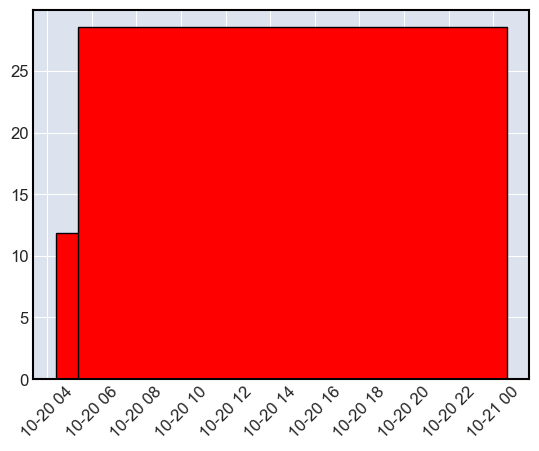

In [55]:
import matplotlib.pyplot as plt
import numpy as np

xpoints = [candle.get("_id") for candle in historical_data]
ypoints = [candle.get("diff") for candle in historical_data]

# fig, ax = plt.subplots(figsize=(20, 4))
plt.bar(xpoints, ypoints, color ='red',edgecolor='black')
plt.xticks(rotation=45)
# plt.show()

In [11]:
import pandas as pd
import mplfinance as mpf

date_list = []
open_list = []
high_list = []
low_list = []
close_list = []

for candle in historical_data:
    date_list.append(candle.get("_id"))
    open_list.append(candle.get("open"))
    high_list.append(candle.get("high"))
    low_list.append(candle.get("low"))
    close_list.append(candle.get("close"))




# Sample OHLC data
data = pd.DataFrame({
    'Date': date_list,
    'Open': open_list,
    'High': high_list,
    'Low': low_list,
    'Close': close_list,
})

# Convert the 'Date' column to a datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Set the 'Date' column as the index
data.set_index('Date', inplace=True)

# Create a candlestick chart
mpf.plot(data, type='candle')


ValueError: Column "High" NOT FOUND in Input DataFrame!
            CHECK that your column names are correct AND/OR
            CHECK for leading or trailing blanks in your column names.

In [17]:
def project_profit(instrument_key: str, entry_time: datetime, stop_loss_percent: float, trailing_percent: float):
    """
    Projects profit/loss based on entry time and trailing stop loss

    The bot will execute sell order whenever the stoploss hits. If stoplos doesn't hit, it will sell at 3PM.

    Here stop loss is update every minute because we have minute interval of data.
    In real world it is suposed to be updated every consecutive api call.

    Args:
        - `instrument_key` (str) : ID of the premium 
        - `entry_time` (datetime) : Time when entered
        - `stop_loss_percent` (float) : % of trailing stop loss set for the premium
        - `trailing_percent` (float) : % of increase before stop loss is updated
    """
    entry_price: float = -1
    stop_loss: float = -1
    exit_price: float = -1
    trailing_target: float = -1

    historical_data = list(candles_collection.find({
        "meta": instrument_key
    }))

        
    value_list = []
    for data in historical_data:
        candle: Candle = Candle(**data)
        
        # Entry 
        if(candle.ts > entry_time and entry_price == -1):
            entry_price = candle.open
            stop_loss = entry_price - entry_price*stop_loss_percent
            trailing_target = entry_price + entry_price*trailing_percent
            print(stop_loss)
        
        if entry_price != -1:
            # Exit
            if (candle.low < stop_loss):
                exit_price = candle.close
                break

            # Trailing Stoploss
            if (candle.high > trailing_target):
                stop_loss = stop_loss + stop_loss*trailing_percent
                trailing_target = trailing_target + trailing_target*trailing_percent
            
            value = {
                "stop_loss": stop_loss,
                "trailing_target": trailing_target,
                "premium": candle.low,
                "time": candle.ts
            }
            value_list.append(value)
            
    
    profit = exit_price - entry_price

    result = {
        "EntryTime": entry_time,
        "ExitTime": candle.ts,
        "EntryPrice": entry_price,
        "ExitPrice": exit_price,
        "Profit": exit_price - entry_price,
        "Profit %":  (profit/entry_price)*100,
    }
    print(result)
    return value_list

In [24]:
value_list = project_profit(
    instrument_key="NSE_FO|50112",
    entry_time=datetime(
        year=2023,
        month=10,
        day=20,
        hour=11,
        minute=47,
        second=0
    ),
    stop_loss_percent=10/100,
    trailing_percent=1/100
)



130.5
{'EntryTime': datetime.datetime(2023, 10, 20, 11, 47), 'ExitTime': datetime.datetime(2023, 10, 20, 13, 45), 'EntryPrice': 145.0, 'ExitPrice': 137.7, 'Profit': -7.300000000000011, 'Profit %': -5.0344827586206975}


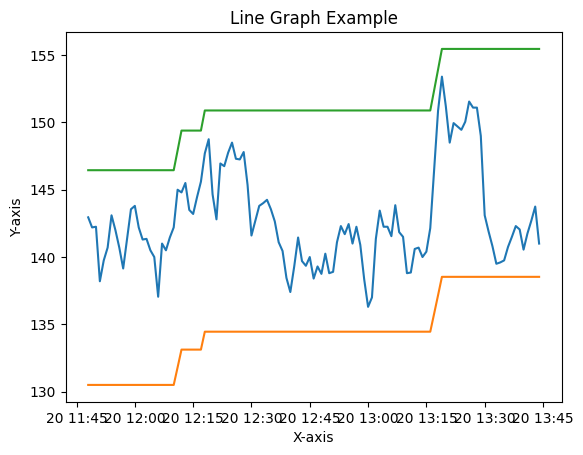

In [25]:
import matplotlib.pyplot as plt

# Data for the line graph
time_list = [value.get("time") for value in value_list]
premium_list = [value.get("premium") for value in value_list]
stop_loss_list = [value.get("stop_loss") for value in value_list]
trailing_target_list = [value.get("trailing_target") for value in value_list]

# Create the line graph
plt.plot(time_list, premium_list, label="Premium")
plt.plot(time_list, stop_loss_list, label="StopLoss")
plt.plot(time_list, trailing_target_list, label="TrailingTarget")

# Adding labels and a title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Line Graph Example')

# Display the plot
plt.show()